In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
import os, sys

import cv2
import cPickle
import matplotlib.pyplot as plt

In [2]:
def random_batch(X, batch_size):
    idxes = np.arange(len(X))
    
    np.random.shuffle(idxes)
    batch_idxes = idxes[:batch_size]
    
    return X[batch_idxes, ...]

In [3]:
def load_images(images_list):
    images = []
    for fname in images_list:
        data_dict = cPickle.load(open(fname))
        
        data_images = data_dict['data']
        gray_data = 0.2125*data_images[:, :1024] + 0.7154*data_images[:, 1024:2048] + 0.0721*data_images[:, 2048:]
        images.extend(gray_data)
        
    images = np.array(images, dtype=np.float32)
    images = images/255.0
    
    return images

In [4]:
images = load_images([
    'data/data_batch_1',
    'data/data_batch_2',
    'data/data_batch_3',
    'data/data_batch_4',
    'data/data_batch_5'
])

test_images = load_images(['data/test_batch'])

In [5]:
learning_rate = 0.005
num_steps = 10000
batch_size = 16

loss_display_step = 1000
summary_step = 100

num_hidden_1 = 512 # 1st layer num features
num_hidden_2 = 256 # 2nd layer num features (the latent dim)

input_size = (32, 32)
num_input = 32*32

activation_function = tf.nn.sigmoid

In [6]:
def model(x):
    image_summary('images', tf.reshape(x, (batch_size, 32, 32, 1)))

    # Encoder Hidden layer with activation #1
    with tf.variable_scope('encoder_1'):
        w1 = tf.Variable(tf.random_normal([num_input, num_hidden_1], stddev=1e-4))
        b1 = tf.Variable(tf.random_normal([num_hidden_1], stddev=1e-4))
        
        layer_1 = activation_function(tf.add(tf.matmul(x, w1), b1))
        histogram_summary('encoder_w1', w1)
        histogram_summary('encoder_b1', b1)
    
    # Encoder Hidden layer with activation #2
    with tf.variable_scope('encoder_2'):
        w2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], stddev=1e-4))
        b2 = tf.Variable(tf.random_normal([num_hidden_2], stddev=1e-4))
        
        layer_2 = activation_function(tf.add(tf.matmul(layer_1, w2), b2))
        histogram_summary('encoder_w2', w2)
        histogram_summary('encoder_b2', b2)

    
    # Building the decoder
    # Decoder Hidden layer with activation #1
    with tf.variable_scope('decoder_1'):
        w1 = tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1], stddev=1e-4))
        b1 = tf.Variable(tf.random_normal([num_hidden_1], stddev=1e-4))
        
        layer_3 = activation_function(tf.add(tf.matmul(layer_2, w1), b1))
        histogram_summary('decoder_w1', w1)
        histogram_summary('decoder_b1', b1)
    
    # Decoder Hidden layer with activation #2
    with tf.variable_scope('decoder_2'):
        w2 = tf.Variable(tf.random_normal([num_hidden_1, num_input], stddev=1e-4))
        b2 = tf.Variable(tf.random_normal([num_input], stddev=1e-4))
        
        layer_4 = activation_function(tf.add(tf.matmul(layer_3, w2),
                                       b2))
        histogram_summary('decoder_w2', w2)
        histogram_summary('decoder_b2', b2)
        
    image_summary('decoded_images', tf.reshape(layer_4, (batch_size, 32, 32, 1)))

    
    return layer_2, layer_4

Step 1: Minibatch Loss: 0.058880
Step 1000: Minibatch Loss: 0.044267
Step 2000: Minibatch Loss: 0.056613
Step 3000: Minibatch Loss: 0.053215
Step 4000: Minibatch Loss: 0.066796
Step 5000: Minibatch Loss: 0.063330
Step 6000: Minibatch Loss: 0.044680
Step 7000: Minibatch Loss: 0.067029
Step 8000: Minibatch Loss: 0.059121
Step 9000: Minibatch Loss: 0.056457
Step 10000: Minibatch Loss: 0.054959
Original Images


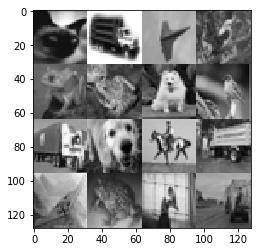

Reconstructed Images


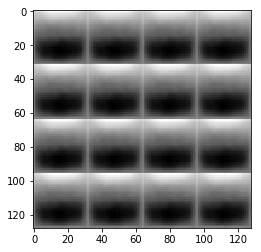

In [7]:
tf.reset_default_graph()

def scalar_summary(name, x):
    tf.summary.scalar(name, x)
    
def image_summary(name, x):
    tf.summary.image(name, x, max_outputs=10)
    
def histogram_summary(name, x):
    tf.summary.histogram(name, x)
    
def loss(y_true, y_pred):
    mean_sq_error = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(mean_sq_error)

    # Write to summary op here
    scalar_summary('loss', mean_sq_error)
    
    return optimizer, mean_sq_error

X = tf.placeholder("float", [None, num_input])
encoder_op, decoder_op = model(X)

# Prediction
y_pred = decoder_op

# Targets (Labels) are the input data.
y_orig = X

optimizer, l = loss(y_orig, y_pred)

init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
with tf.Session() as sess:
    # Run the initializer
    summary_writer = tf.summary.FileWriter('summary_dir', sess.graph)
    merged = tf.summary.merge_all()

    sess.run(init)
    
    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_images = random_batch(images, batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, op_loss = sess.run([optimizer, l], feed_dict={X: batch_images})
        # Display logs per step
        if i % loss_display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, op_loss))
        if i % summary_step == 0 or i == 1:
            summary = sess.run(merged, feed_dict={X: batch_images})
            summary_writer.add_summary(summary, i)
    
    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((input_size[0] * n, input_size[1] * n))
    canvas_recon = np.empty((input_size[0] * n, input_size[1] * n))
    for i in range(n):
        # MNIST test set
        batch_x = random_batch(test_images, batch_size)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * input_size[0]:(i + 1) * input_size[0], j * input_size[1]:(j + 1) * input_size[1]] = \
                batch_x[j].reshape([input_size[0], input_size[1]])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * input_size[0]:(i + 1) * input_size[0], j * input_size[1]:(j + 1) * input_size[1]] = \
                g[j].reshape([input_size[0], input_size[1]])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()